In [2]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

ImportError: cannot import name 'plotting'

In [ ]:
env = gym.envs.make("MountainCar-v0")

In [4]:
class Estimator():
    """
    Value Function approximator. 
    """
    def __init__(self):
        self.model = SGDRegressor(learning_rate="constant")
        model.partial_fit([self.featurize_state(env.reset())], [0]) # initialize to avoid error
        
        
    def featurize(features):
        return np.array(features)
    

    def feature_extractor(self, state, bet_amount, bet_team):
        """
        Returns the featurized representation for a state.
        """
        def getOdds(m):
            pass
        
        def getWinProbs(m):
            pass
        
        match, cash = state
        features = [bet_amount, cash, odds[0], odds[1], odds[2], win_probs[0], win_probs[1], win_probs[2]]
        return featurize(features)
    
    def predict(self, s):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
        """
        match, cash = s
        predictions = []
        for bet_amount in range(cash + 1):
            for bet_team in range(3):
                features = self.feature_extractor(s, bet_amount, bet_team)
                prediction = m.predict(features)[0]
                predictions.append(prediction)
        
        return np.array(predictions)

    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        bet_amount, bet_team = a
        features = self.feature_extractor(s, bet_amount, bet_team)
        self.model.partial_fit([features], [y])

In [5]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
                        
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            if next_action is None:
                action_probs = policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            
            # Use this code for Q-Learning
            # Q-Value TD Target
            td_target = reward + discount_factor * np.max(q_values_next)
            
            # Use this code for SARSA TD Target for on policy-training:
            # next_action_probs = policy(next_state)
            # next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            # td_target = reward + discount_factor * q_values_next[next_action]
            
            # Update the function approximator using our target
            estimator.update(state, action, td_target)
            
            if i % 10 == 0:
                print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [7]:
estimator = Estimator()

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [8]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 100, epsilon=0.0)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 110 @ Episode 100/100 (-123.0)

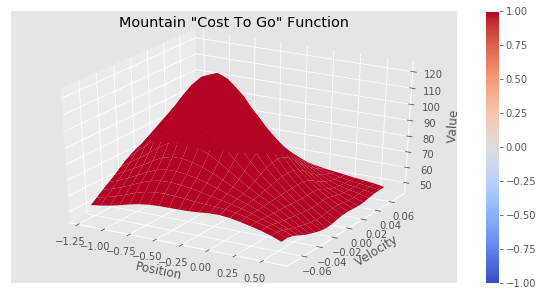

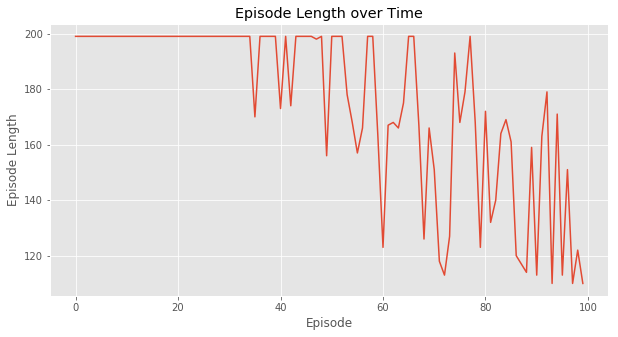

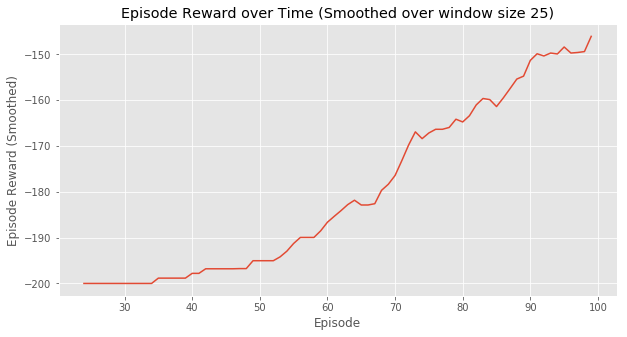

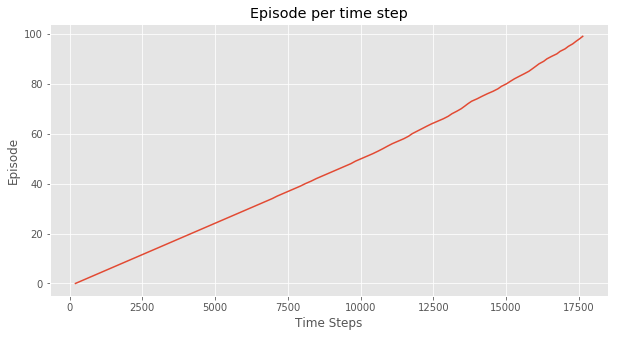

(<matplotlib.figure.Figure at 0x114d1a940>,
 <matplotlib.figure.Figure at 0x1151e80f0>)

In [9]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)